In [2]:
import matplotlib.pyplot as plt

import pandas as pd

In [3]:
df = pd.read_csv("./../data/preproc/market/food_df.csv", index_col=0)

In [4]:
df_main = df[df["상권업종중분류명"] == "유흥주점"]
column_using = [
    "상호명",
    "상권업종소분류명",
    "행정동명",
    "법정동명",
    "도로명",
    "도로명주소",
    "경도",
    "위도",
]

df_main = df_main.loc[:, column_using]

In [5]:
location_df = df_main.loc[:, ["경도", "위도"]]

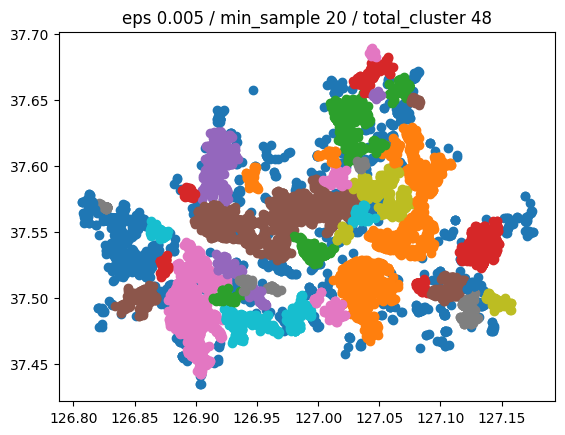

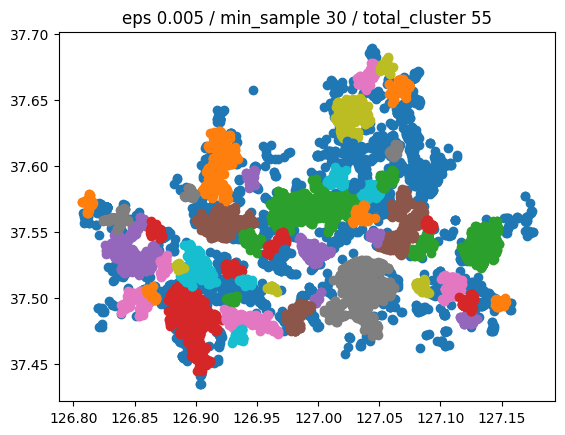

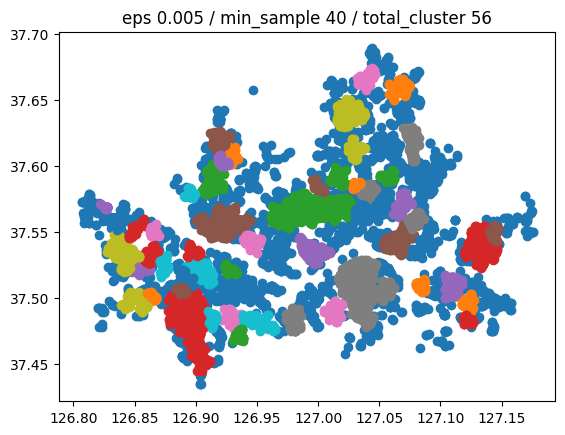

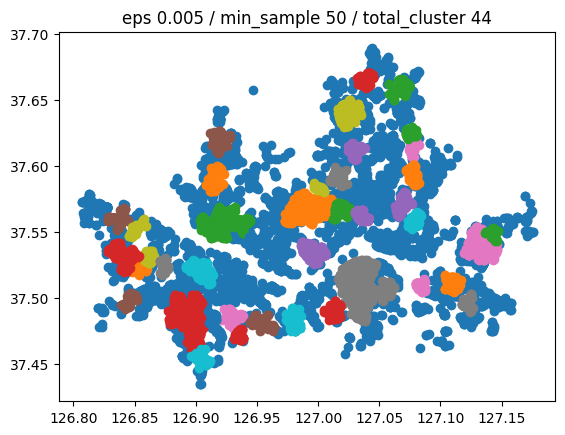

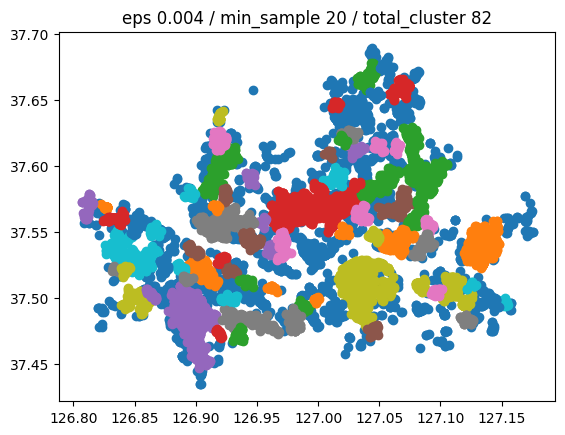

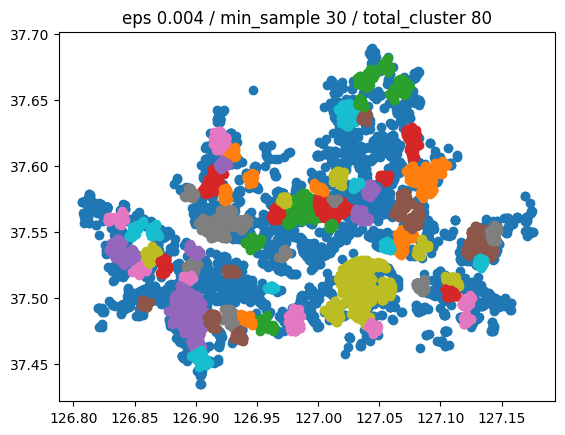

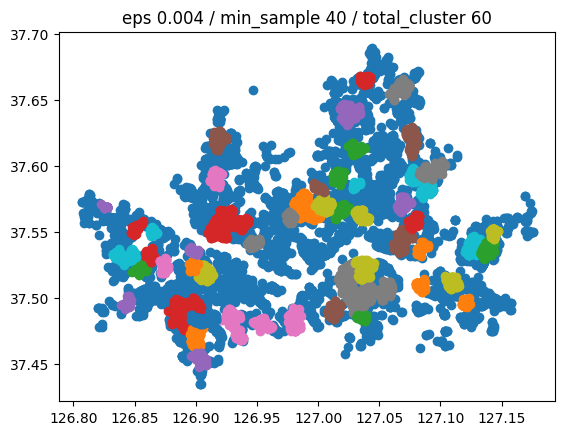

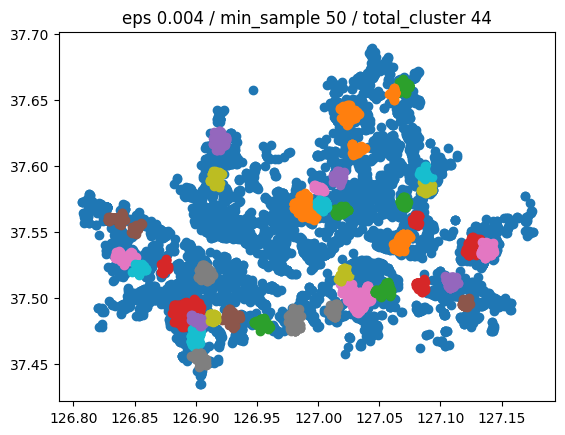

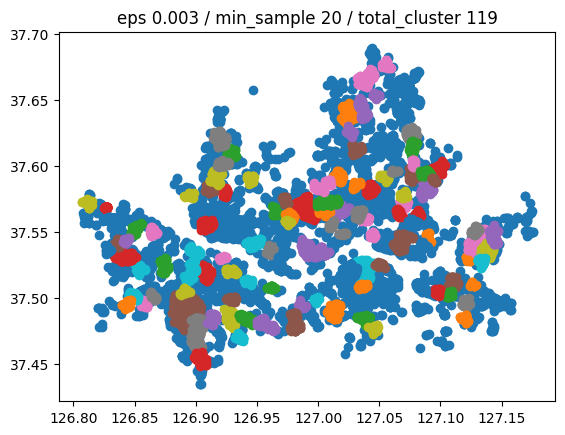

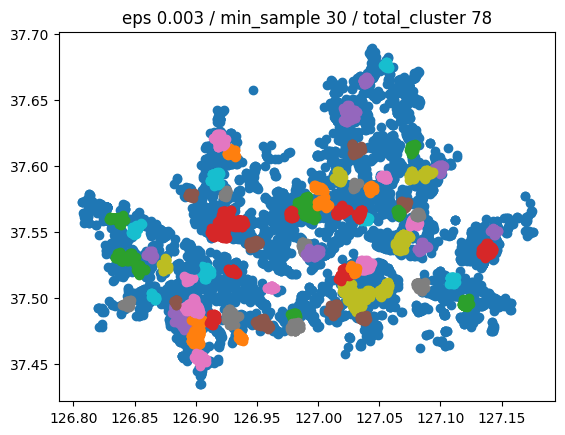

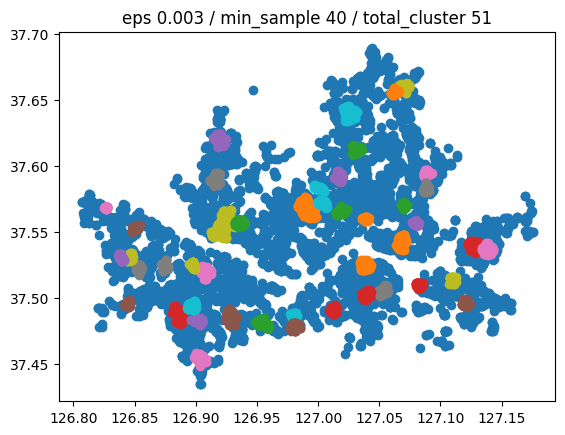

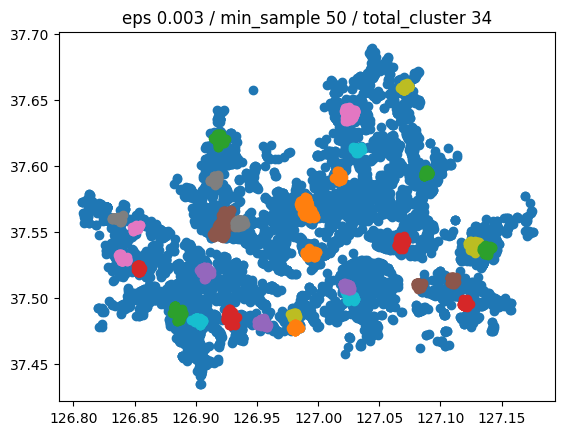

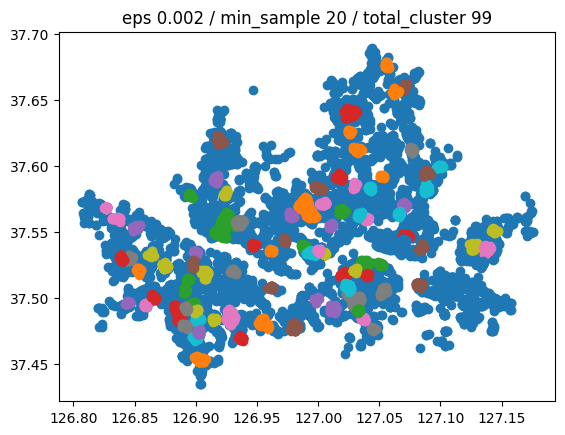

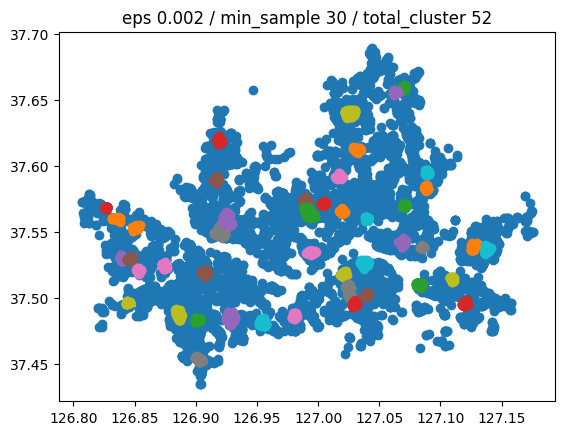

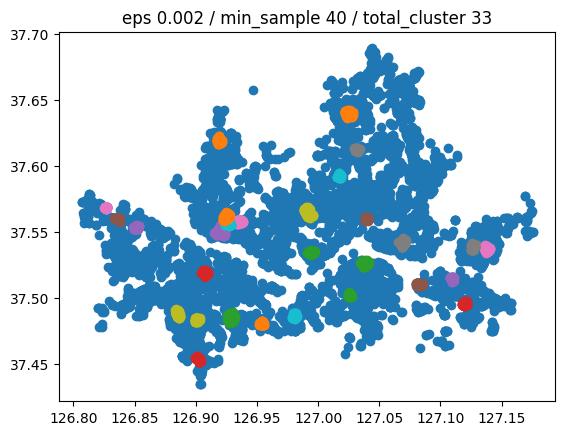

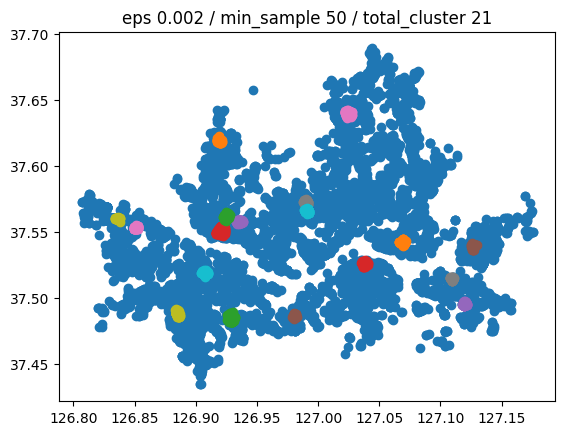

In [6]:
from sklearn.cluster import DBSCAN

for eps in [0.005, 0.004, 0.003, 0.002]:
    for min_sample in [20, 30, 40, 50]:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        location_df["cluster"] = dbscan.fit_predict(location_df.loc[:,["경도", "위도"]])
        groups = location_df.groupby("cluster")

        fig, ax = plt.subplots()
        for name, group in groups:
            ax.plot(group["경도"], group["위도"], marker="o", linestyle="")
        plt.title(f"eps {eps} / min_sample {min_sample} / total_cluster {len(set(location_df['cluster']))}")
        plt.show()

In [7]:
from sklearn.cluster import KMeans

# for n_clusters in [10, 15, 20, 25, 30]:
#     kmeans = KMeans(n_clusters=n_clusters)
#     location_df["cluster"] = kmeans.fit_predict(location_df.loc[:,["경도", "위도"]])
#     groups = location_df.groupby("cluster")

#     fig, ax = plt.subplots()
#     for name, group in groups:
#         ax.plot(group["경도"], group["위도"], marker="o", linestyle="")
#     plt.title(
#         f"n_clusters {n_clusters} / total_cluster {len(set(location_df['cluster']))}"
#     )
#     plt.show()

In [10]:
kmeans = KMeans(n_clusters=30)
df_main["cluster"] = kmeans.fit_predict(df_main.loc[:,["경도", "위도"]])

/opt/homebrew/anaconda3/envs/quant_trading/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
cluster_std = df_main.groupby("cluster")[["경도", "위도"]].std()
cluster_std["total"] = cluster_std.sum(axis=1)

In [65]:
import numpy as np
from scipy.spatial import ConvexHull

def estimate_cluster_area(data):
    if len(data) == 0:
        return 0
    if len(data) == 1:
        return 0
    hull = ConvexHull(data)
    return hull.volume


cluster_areas = list()
for cluster_id, cluster_data in df_main.groupby("cluster")[["위도", "경도"]]:
    cluster_area = estimate_cluster_area(cluster_data.values)
    cluster_areas.append({"cluster": cluster_id, "cluster_area": cluster_area})

In [70]:
cluster_df = pd.concat(
    [cluster_std, pd.DataFrame(cluster_areas).set_index("cluster")], axis=1
)

In [72]:
cluster_df = cluster_df.loc[:, ["total", "cluster_area"]]
cluster_df.columns = ["std", "area"]

In [79]:
cluster_df["sum"] = cluster_df["std"] + cluster_df["area"]

In [81]:
cluster_df.nsmallest(10, "sum")

,std,area,sum
cluster,,,
3,0.014498,0.001019,0.015517
14,0.014648,0.000948,0.015596
1,0.015535,0.000774,0.016309
24,0.015535,0.001299,0.016833
4,0.015872,0.001021,0.016893
19,0.016075,0.000844,0.016919
5,0.015992,0.001325,0.017317
29,0.016377,0.001177,0.017554
23,0.016574,0.001038,0.017612


In [84]:
cluster_mean_location = df_main.groupby("cluster")[["경도", "위도"]].mean()

In [86]:
cluster_mean_location.head().to_clipboard()

In [97]:
from scipy.spatial.distance import euclidean
# import pandas as pd

# # 클러스터 좌표 데이터
# data = {
#     'cluster': [0, 1, 2, 3, 4],
#     '경도': [127.0281443353326, 126.8423193311807, 127.08869416188116, 126.92358159533032, 126.89195367316981],
#     '위도': [37.49469041752459, 37.52984455964278, 37.59123971025409, 37.55541554242299, 37.49030538708165]
# }

# df = pd.DataFrame(data)

# # 클러스터 간 거리 계산
# for i in range(len(df)):
#     for j in range(i+1, len(df)):
#         dist = euclidean((df['경도'][i], df['위도'][i]), (df['경도'][j], df['위도'][j]))
#         print(f"Cluster {df['cluster'][i]} 와 Cluster {df['cluster'][j]} 의 거리: {dist}")


In [104]:
def calc_distance(a, b, target_location):
    return euclidean([a, b], target_location)

In [112]:
result_dict = dict()

In [125]:
cluster_ids = cluster_mean_location.index
for cluster_id in cluster_ids:
    feature_location = cluster_mean_location[
        cluster_mean_location.index == cluster_id
    ].to_numpy()[0]
    target_location_df = cluster_mean_location[
        cluster_mean_location.index != cluster_id
    ]
    cluster_near_3_dist = (
        target_location_df.apply(
            lambda x: calc_distance(x["경도"], x["위도"], feature_location),
            axis=1,
        )
        .min()
        # .nsmallest(3)
        # .mean()
    )
    result_dict[cluster_id] = cluster_near_3_dist

In [126]:
cluster_distance_df = pd.DataFrame([result_dict]).T
cluster_distance_df.index.name = 'cluster'
cluster_distance_df.columns = ['distance']

In [127]:
cluster_distance_df.nlargest(10, "distance")

,distance
cluster,
6,0.048106
17,0.039592
5,0.038773
20,0.038583
13,0.036202
18,0.035976
29,0.035242
26,0.033685
28,0.033664


In [128]:
df_main[df_main['cluster'] == 6]

,상호명,상권업종소분류명,행정동명,법정동명,도로명,도로명주소,경도,위도,cluster
201,사나포차,소주방/포장마차,성내1동,성내동,서울특별시 강동구 천호옛길,"서울특별시 강동구 천호옛길 14, (성내동)",127.121413,37.530709,6
1104,깡통포차,소주방/포장마차,천호2동,천호동,서울특별시 강동구 구천면로41길,"서울특별시 강동구 구천면로41길 22, (천호동, 연리지빌)",127.132961,37.546734,6
1464,오로라,호프/맥주,길동,길동,서울특별시 강동구 천중로,"서울특별시 강동구 천중로 235, (길동)",127.146438,37.540822,6
2678,쥬리아,룸살롱/단란주점,성내1동,성내동,서울특별시 강동구 성안로,"서울특별시 강동구 성안로 41, (성내동)",127.130366,37.527513,6
2984,오랜만이야,소주방/포장마차,천호2동,천호동,서울특별시 강동구 올림픽로70길,"서울특별시 강동구 올림픽로70길 56-4, (천호동)",127.126602,37.538893,6
...,...,...,...,...,...,...,...,...,...
355976,애플2,룸살롱/단란주점,길동,길동,서울특별시 강동구 양재대로111길,"서울특별시 강동구 양재대로111길 32, (길동)",127.137888,37.537489,6
356239,비노델비노,꼬치구이전문점,천호3동,천호동,서울특별시 강동구 천호대로,"서울특별시 강동구 천호대로 1089, (천호동, 강동헤르셔)",127.133078,37.536562,6
356392,팬,호프/맥주,길동,길동,서울특별시 강동구 천중로40길,"서울특별시 강동구 천중로40길 55, (길동)",127.138113,37.538554,6
356522,그랜드호프,꼬치구이전문점,상일1동,상일동,서울특별시 강동구 천호대로219길,"서울특별시 강동구 천호대로219길 10, (상일동)",127.170569,37.546436,6
